# Project 1
## Discrete Event Simulations: Loading (and Unloading) an Airplane
### Hiram College: Computer Simulation (CPSC 381)
**Description:** This project will utilize Discrete Event Simulation (DES) to simulate the unloading of a plane to determine the average time for a flight to unload every passenger on a full flight based on the number of rows and seats in the plane.  

In [437]:
import simpy
import string
import random

class Passenger:
    def __init__(self, id, row: int, seat: str, speed: float, has_bag: bool = False, bag_time: float = 0):
        self.id = id
        self.row = row
        self.seat = seat
        self.speed = speed
        self.bag_time = bag_time
        self.unloaded = False
        self.process_time: float = 0.0

    def get_has_bag(self):
        return self.has_bag

    def get_bag_time(self):
        return self.bag_time

    def get_data(self):
        """Method to get the passenger data.
    
        Returns:
            List: Tuple of the passenger data.
        """
        return [self.id, self.row, self.seat, self.speed, self.unloaded]

    def get_id(self):
        """Method to get the passenger id.
    
        Returns:
            int: The passenger id.
        """
        return self.id

    def get_row(self):
        """Method to get the passenger row.
    
        Returns:
            int: The passenger row.
        """
        return self.row

    def get_seat(self):
        """Method to get the passenger seat.
    
        Returns:
            str: The passenger seat.
        """
        return self.seat

    def get_speed(self):
        """Method to get the passenger speed.
    
        Returns:
            float: The passenger speed.
        """
        return self.speed

    def set_process_time(self, process_time: float):
        """Method to set the passenger process time.
    
        Args:
            process_time (float): The process time to set for the passenger.
        """
        self.process_time = process_time

    def get_process_time(self):
        """Method to get the passenger process time.
    
        Returns:
            float: The passenger process time.
        """
        return self.process_time

class Plane:
    def __init__(self, env: simpy.Environment, id, num_rows: int, num_seats_per_row: int, sim_type: int, special: bool, min_passenger_speed: float = 3, max_passenger_speed: float = 6):
        self.env = env
        self.id = id
        self.num_rows = num_rows
        self.num_seats_per_row = num_seats_per_row
        self.min_passenger_speed = min_passenger_speed
        self.max_passenger_speed = max_passenger_speed
        self.sim_type = sim_type
        self.special = special
        self.num_passengers = self.num_rows * self.num_seats_per_row
        self.process_time: float = 0.0
        
        self.loaded_passengers = []
        self.unloaded_passengers = []

        self._setup_plane(self.loaded_passengers, self.unloaded_passengers, self.sim_type, self.special)

    def _setup_plane(self, loaded_passengers, unloaded_passengers, sim_type, special):
        """Internal method to set up the airplane for either loading or unloading.

        Args:
            loaded_passengers (list[Passenger]): List to be populated with loaded passengers.
            unloaded_passengers (list[Passenger]): List to be populated with unloaded passengers.
            sim_type (int): 0 for unloading, 1 for loading.
    
        Returns:
            None: Modifies the passenger lists in-place.
    
        Raises:
            ValueError: If `sim_type` is not 0 or 1.
        """
        if self.special != False and self.special != True:
            raise ValueError("'special' must be either True (special) or False (not special)")
        if self.special:
            has_bag = random.random() < 0.75
            if has_bag:
                bag_time = random.triangular(4, 10, 6)
            else:
                bag_time = 0.0

        uppercase_alphabet = list(string.ascii_uppercase)
        seat_labels = []
        for i in range(self.num_seats_per_row):
            seat_labels.append(uppercase_alphabet[i])

        row = 1
        seat = seat_labels[0]
        seat_step = 0
        for i in range(self.num_passengers):
            seat = seat_labels[seat_step]
            
            # Create new passenger (speed is a random float between min_passenger_speed and max_passenger_speed)
            if self.special:
                new_passenger = Passenger(i, row, seat, random.uniform(self.min_passenger_speed, self.max_passenger_speed), has_bag, bag_time)
            else:
                new_passenger = Passenger(i, row, seat, random.uniform(self.min_passenger_speed, self.max_passenger_speed))
            if sim_type == 0:
                loaded_passengers.append(new_passenger)
            elif sim_type == 1:
                unloaded_passengers.append(new_passenger)
            else:
                raise ValueError("'sim_type' must be either 0 (unload) or 1 (load)")
            
            if seat == seat_labels[-1]:
                row += 1
                seat_step = 0
            else:
                seat_step += 1
    
    def unload_passenger(self, passenger):
        """Method to unload a passenger from the airplane.

        Args:
            passenger (Passenger): Passenger to be unloaded.
    
        Returns:
            Passenger: The passenger that was processed.
        """
        self.idle = False
        time = passenger.get_row() * 3 / passenger.get_speed()
        yield self.env.timeout(delay=time)
        passenger.set_process_time(self.env.now / 60)
        # print(f"Unloading passenger {passenger.id} at {self.env.now/60} minutes.")
        passenger.unloaded = True
        self.idle = True
        return passenger

    def unload_airplane(self):
        """Method to unload all loaded passengers from the airplane.
    
        Returns:
            None: Modifies the passenger lists and updates unloading results.
        """
        while len(self.loaded_passengers) > 0:
            p = self.loaded_passengers[0]
            yield self.env.process(self.unload_passenger(p))
            self.loaded_passengers.remove(p)
            self.unloaded_passengers.append(p)
            if len(self.loaded_passengers) == 0:
                self.process_time = p.get_process_time()
        # print(f"Unloaded airplane {self.id} in {self.process_time} minutes")

    def unload_passenger_special(self, passenger):
        self.idle = False
        time = passenger.get_row() * 3 / passenger.get_speed()
        bag_time = passenger.get_bag_time()
        blockers = 0
        if passenger.get_seat() in ("A", "F"):
            blockers = 2
        elif passenger.get_seat() in ("B", "E"):
            blockers = 1
        interference = 0.0
        if blockers > 0 and random.random() < 0.6:
            interference = random.triangular(1, 5, 2) * blockers
        total_time = time + bag_time + interference
        yield self.env.timeout(total_time)
        passenger.set_process_time(self.env.now / 60)
        passenger.unloaded = True
        self.idle = True
        return passenger

    def unload_airplane_special(self):
        while len(self.loaded_passengers) > 0:
            p = self.loaded_passengers[0]
            yield self.env.process(self.unload_passenger_special(p))
            self.loaded_passengers.remove(p)
            self.unloaded_passengers.append(p)
            if len(self.loaded_passengers) == 0:
                self.process_time = p.get_process_time()
                
    def load_passenger(self, passenger):
        pass # future logic

    def load_airplane(self):
        pass # future logic

    def get_process_time(self):
        """Method to get the time it took to process the plane.
    
        Returns:
            float: The total process time.
        """
        return self.process_time

    def print_passenger_data(self):
        """Method to print all of the passenger data.
    
        Returns:
            None: Iteratively prints the passenger data.
        """
        print("Number of passengers on plane: " + str(len(self.loaded_passengers)))
        for i in range(len(self.loaded_passengers)):
            passenger = self.loaded_passengers[i]
            print(passenger.get_data())

In [446]:
class UnloadSimRunner:
    def __init__(self, num_rows_options, num_seats_per_row: int, num_runs: int):
        self.num_rows_options = num_rows_options
        self.num_seats_per_row = num_seats_per_row
        self.num_runs = num_runs
        
        self.unload_results = []
        self.num_rows_options_step = 0
        
    def _run_unload_sim(self, special: bool):
        run_times = []
        num_rows = self.num_rows_options[self.num_rows_options_step]
        num_passengers = num_rows * self.num_seats_per_row
        if self.num_rows_options_step < len(self.num_rows_options):
            self.num_rows_options_step += 1
        if special:
            print(f"Running {num_passengers}-seat ({num_rows} rows, {self.num_seats_per_row} seats per row) special airplane unloading simulation...")
        else:
            print(f"Running {num_passengers}-seat ({num_rows} rows, {self.num_seats_per_row} seats per row) airplane unloading simulation...")
        for i in range(self.num_runs):
            env = simpy.Environment()
            plane = Plane(env, i, num_rows, self.num_seats_per_row, 0, special)
            # plane.print_passenger_data()
            if special:
                env.process(plane.unload_airplane_special())
            else:
                env.process(plane.unload_airplane())
            env.run()
            run_times.append(plane.get_process_time())
            
        import statistics
        avg_unload_time = statistics.mean(run_times)
        std_dev = statistics.stdev(run_times)

        self.unload_results.append((avg_unload_time, std_dev))
        print(f"Average unload time after {self.num_runs} runs "
              f"for a {num_passengers}-seat airplane was "
              f"{avg_unload_time:.3f} minutes "
              f"(std dev = {std_dev:.3f})\n")

    def run_unload_sim(self, special: bool):
        for i in range(len(self.num_rows_options)):
            self._run_unload_sim(special)

    def plot_results(self, plt, sepcial):
        means = []
        stds = []
        for result in self.unload_results:
            means.append(result[0])
            stds.append(result[1])
        plt.errorbar(self.num_rows_options, means, yerr=stds, fmt='ro')
        plt.xlabel(f"Number of Rows ({self.num_seats_per_row} Seats/Row)")
        plt.ylabel("Time (Minutes)")
        if special:
            title_string = "Special"
        else:
            title_string = "Basic"
        plt.title(f"Average Airplane Unloading Times After {self.num_runs} Runs ({title_string})")
        plt.show()

Running 100-seat (25 rows, 4 seats per row) airplane unloading simulation...
Average unload time after 30 runs for a 100-seat airplane was 15.038 minutes (std dev = 0.347)

Running 120-seat (30 rows, 4 seats per row) airplane unloading simulation...
Average unload time after 30 runs for a 120-seat airplane was 21.589 minutes (std dev = 0.331)

Running 140-seat (35 rows, 4 seats per row) airplane unloading simulation...
Average unload time after 30 runs for a 140-seat airplane was 29.065 minutes (std dev = 0.519)

Running 160-seat (40 rows, 4 seats per row) airplane unloading simulation...
Average unload time after 30 runs for a 160-seat airplane was 37.832 minutes (std dev = 0.835)

Running 180-seat (45 rows, 4 seats per row) airplane unloading simulation...
Average unload time after 30 runs for a 180-seat airplane was 47.760 minutes (std dev = 0.719)



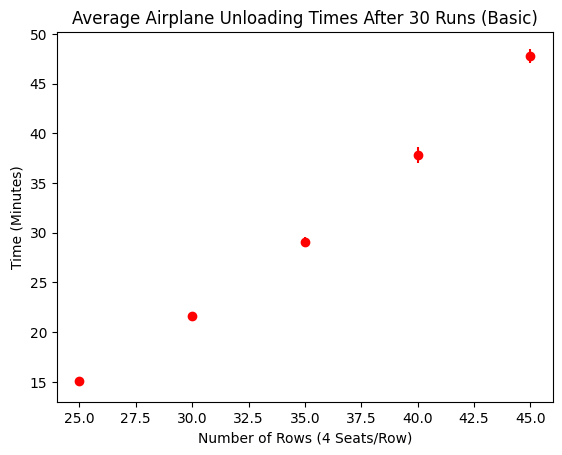

In [447]:
import matplotlib.pyplot as plt

num_rows_options = [25, 30, 35, 40, 45]
num_seats_per_row: int = 4
num_runs: int = 30
special = False

unload_sim_runner = UnloadSimRunner(num_rows_options, num_seats_per_row, num_runs)
unload_sim_runner.run_unload_sim(special)
unload_sim_runner.plot_results(plt, special)

Running 100-seat (25 rows, 4 seats per row) airplane unloading simulation...
Average unload time after 30 runs for a 100-seat airplane was 26.708 minutes (std dev = 4.983)

Running 120-seat (30 rows, 4 seats per row) airplane unloading simulation...
Average unload time after 30 runs for a 120-seat airplane was 34.674 minutes (std dev = 5.915)

Running 140-seat (35 rows, 4 seats per row) airplane unloading simulation...
Average unload time after 30 runs for a 140-seat airplane was 42.516 minutes (std dev = 8.277)

Running 160-seat (40 rows, 4 seats per row) airplane unloading simulation...
Average unload time after 30 runs for a 160-seat airplane was 55.617 minutes (std dev = 8.021)

Running 180-seat (45 rows, 4 seats per row) airplane unloading simulation...
Average unload time after 30 runs for a 180-seat airplane was 67.422 minutes (std dev = 8.605)



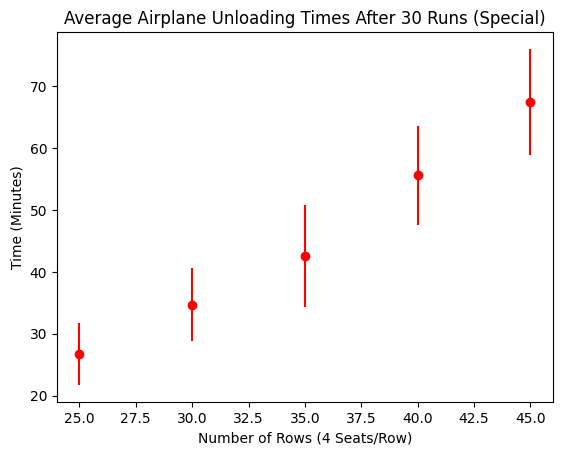

In [448]:
special = True

unload_sim_runner_special = UnloadSimRunner(num_rows_options, num_seats_per_row, num_runs)
unload_sim_runner_special.run_unload_sim(special)
unload_sim_runner_special.plot_results(plt, special)